In [ ]:
import zipfile
import os
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/Capstone/Data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_labels_path = '/content/drive/My Drive/Capstone/Data/train.xlsx'
test_labels_path = '/content/drive/My Drive/Capstone/Data/test.xlsx'
val_labels_path = '/content/drive/My Drive/Capstone/Data/validation.xlsx'

In [ ]:
# Load the label data from the Excel files
train_df = pd.read_excel(train_labels_path)
test_df = pd.read_excel(test_labels_path)
val_df = pd.read_excel(val_labels_path)

In [ ]:
test_df

,class,image
0,Mass,00014105_001.png
1,Mass,00016778_022.png
2,Mass,00016311_005_3903.png
3,Mass,00019884_004.png
4,Mass,00019893_000_1259.png
...,...,...
29995,Fibrosis,00023606_000_478.png
29996,Fibrosis,00004577_004_6802.png
29997,Fibrosis,00010967_000_1643.png
29998,Fibrosis,00019745_002.png


In [ ]:
%%time
import zipfile
import concurrent.futures
zf = zipfile.ZipFile('/content/drive/My Drive/Capstone/Data/TrainTestVal-Images.zip')
def unzip(file):
    zf.extract(file)
with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(unzip, zf.infolist())

CPU times: user 1min 23s, sys: 53.9 s, total: 2min 17s
Wall time: 1min 2s


In [ ]:
import os

# Replace with the actual path to your images folder
images_folder_path = '/content/TrainTestVal-Images/Train'

# List of image file extensions we're looking for
image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']

# Initialize a counter
image_count = 0

# Walk through all files and folders within the images folder
for root, dirs, files in os.walk(images_folder_path):
    for file in files:
        # Check if the file has one of the image file extensions
        if any(file.lower().endswith(ext) for ext in image_extensions):
            image_count += 1

print(f'The folder contains {image_count} image(s).')


The folder contains 85334 image(s).


In [ ]:
import os
import pandas as pd

# Define the paths to your image directories and annotation files
train_annotations_path = '/content/drive/My Drive/Capstone/Data/train.xlsx'
test_annotations_path = '/content/drive/My Drive/Capstone/Data/test.xlsx'
validation_annotations_path = '/content/drive/My Drive/Capstone/Data/validation.xlsx'

train_img_dir = '/content/TrainTestVal-Images/Train'
test_img_dir = '/content/TrainTestVal-Images/Test'
validation_img_dir = '/content/TrainTestVal-Images/Validation'

# A function to check if files exist
def check_images_exist(annotations_path, img_dir):
    # Read the annotations file
    df = pd.read_excel(annotations_path)
    # Assuming the Excel file has a column named 'filename' with the image file names
    missing_files = []
    for filename in df['image']:
        file_path = os.path.join(img_dir, filename)
        if not os.path.isfile(file_path):
            missing_files.append(filename)
    return missing_files

# Check each dataset
missing_train_files = check_images_exist(train_annotations_path, train_img_dir)
missing_test_files = check_images_exist(test_annotations_path, test_img_dir)
missing_validation_files = check_images_exist(validation_annotations_path, validation_img_dir)

# Report the results
if missing_train_files:
    print(f'Missing training files: {missing_train_files}')
else:
    print('All training files are present.')

if missing_test_files:
    print(f'Missing test files: {missing_test_files}')
else:
    print('All test files are present.')

if missing_validation_files:
    print(f'Missing validation files: {missing_validation_files}')
else:
    print('All validation files are present.')


All training files are present.
All test files are present.
All validation files are present.


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_excel(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
      img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
      image = Image.open(img_path).convert('RGB')  # Convert image to RGB
      label = self.img_labels.iloc[idx, 0]
      # Convert the label from string to integer using the mapping dictionary
      label = class_to_idx[label]
      if self.transform:
          image = self.transform(image)
      return image, label

# Define transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = CustomImageDataset(annotations_file='/content/drive/My Drive/Capstone/Data/train.xlsx',
                                   img_dir='/content/TrainTestVal-Images/Train',
                                   transform=transform)

test_dataset = CustomImageDataset(annotations_file='/content/drive/My Drive/Capstone/Data/test.xlsx',
                                  img_dir='/content/TrainTestVal-Images/Test',
                                  transform=transform)

val_dataset = CustomImageDataset(annotations_file='/content/drive/My Drive/Capstone/Data/validation.xlsx',
                                 img_dir='/content/TrainTestVal-Images/Validation',
                                 transform=transform)




class_to_idx = {class_name: index for index, class_name in enumerate(pd.unique(train_dataset.img_labels['class']))}
class_to_idx



from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)





## FIRST MODEL

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary
# Import the copy module
import copy

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained ResNet model
model = models.resnet50(pretrained=True)


num_classes = 15
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Move the model to the GPU if available
model = model.to(device)

# Summary of the model (optional, it requires torchsummary to be installed)
# summary(model, input_size=(3, 224, 224))

# Assume the rest of the setup code above remains the same...

# Define the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_acc = 0.0
    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model_trained = train_model(model, criterion, optimizer, lr_scheduler, num_epochs=30)

# Save the model (optional)
torch.save(model_trained.state_dict(), '/content/drive/My Drive/Capstone/model_resnet50.pth')


# Save the model (optional)
# torch.save(model_trained.state_dict(), 'model_resnet50.pth')

# To evaluate on the test set
model.eval()
# Then loop over your test_loader


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train Loss: 2.4384 Acc: 0.1921
val Loss: 2.5763 Acc: 0.1953
train Loss: 2.2719 Acc: 0.2444
val Loss: 2.5833 Acc: 0.2219
train Loss: 2.2115 Acc: 0.2617
val Loss: 2.2411 Acc: 0.2586
train Loss: 2.1725 Acc: 0.2744
val Loss: 2.2408 Acc: 0.2542
train Loss: 2.1340 Acc: 0.2850
val Loss: 2.3105 Acc: 0.2568
train Loss: 2.1035 Acc: 0.2937
val Loss: 3.3217 Acc: 0.2468
train Loss: 2.0821 Acc: 0.3005
val Loss: 3.2603 Acc: 0.2120
train Loss: 1.9682 Acc: 0.3334
val Loss: 1.9926 Acc: 0.3277
train Loss: 1.9226 Acc: 0.3498
val Loss: 1.9892 Acc: 0.3306
train Loss: 1.8974 Acc: 0.3556
val Loss: 1.9583 Acc: 0.3399
train Loss: 1.8793 Acc: 0.3601
val Loss: 1.9512 Acc: 0.3419
train Loss: 1.8632 Acc: 0.3638
val Loss: 1.9890 Acc: 0.3378
train Loss: 1.8399 Acc: 0.3730
val Loss: 1.9451 Acc: 0.3440
train Loss: 1.8197 Acc: 0.3785
val Loss: 1.9164 Acc: 0.3505
train Loss: 1.7795 Acc: 0.3906
val Loss: 1.8956 Acc: 0.3613
train Loss: 1.7705 Acc: 0.3938
val Loss: 1.8947 Acc: 0.3586
train Loss: 1.7665 Acc: 0.3971
val Loss:

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
# Import the copy module
import copy

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model architecture (must be the same as when the model was saved)
num_classes = 15  # Make sure this is the same as when you trained the model
model = models.resnet50(pretrained=False)  # pretrained=False since we're loading our trained weights
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Load the saved weights
model.load_state_dict(torch.load('/content/drive/My Drive/Capstone/model_resnet50.pth', map_location=device))

# Move the model to the GPU if available
model = model.to(device)

# Define your criterion here (should be the same as the one used during training)
criterion = nn.CrossEntropyLoss()

# Assuming your DataLoader is named 'test_loader'
# Replace 'your_test_loader' with the actual variable name of your test DataLoader

# Function to evaluate the model
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    running_corrects = 0

    # No need to track gradients for validation
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass to get outputs
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Get predictions
            _, preds = torch.max(outputs, 1)

            # Update running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    # Calculate average loss and accuracy over all test data
    total_loss = running_loss / len(test_loader.dataset)
    total_acc = running_corrects.double() / len(test_loader.dataset)

    print(f'Test Loss: {total_loss:.4f} Acc: {total_acc:.4f}')

# Evaluate the model using the test dataset
evaluate_model(model, test_loader, criterion)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Test Loss: 1.8935 Acc: 0.3554


##SECOND MODEL

In [ ]:
class_to_idx

{'Mass': 0,
 'Cardiomegaly': 1,
 'Atelectasis': 2,
 'Effusion': 3,
 'Pneumothorax': 4,
 'No Finding': 5,
 'Subcutaneous Emphysema': 6,
 'Nodule': 7,
 'Pleural Thickening': 8,
 'Edema': 9,
 'Pneumonia': 10,
 'Emphysema': 11,
 'Infiltration': 12,
 'Consolidation': 13,
 'Fibrosis': 14}

In [ ]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_excel(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = Image.open(img_path).convert('RGB')  # Convert image to RGB
        label = self.img_labels.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Assuming you have a function to transform your labels
def target_transform(label):
    # Your code to transform the label if necessary, e.g., a class to index mapping
    return class_to_idx[label]



# Create datasets
train_dataset = CustomImageDataset(
    annotations_file='/content/drive/My Drive/Capstone/Data/train.xlsx',
    img_dir='/content/TrainTestVal-Images/Train',
    transform=transform,
    target_transform=target_transform
)

test_dataset = CustomImageDataset(
    annotations_file='/content/drive/My Drive/Capstone/Data/test.xlsx',
    img_dir='/content/TrainTestVal-Images/Test',
    transform=transform,
    target_transform=target_transform
)


# Create the validation dataset
val_dataset = CustomImageDataset(
    annotations_file='/content/drive/My Drive/Capstone/Data/validation.xlsx',
    img_dir='/content/TrainTestVal-Images/Validation',
    transform=transform,
    target_transform=target_transform
)



# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)


In [ ]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy

# Custom dataset
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_excel(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 0]
        if self.target_transform:
            label = self.target_transform(label)
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transformations
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Assuming you have a function or dictionary to transform your labels

def target_transform(label):
    return class_to_idx[label]

# Initialize datasets
train_dataset = CustomImageDataset(
    annotations_file='/content/drive/My Drive/Capstone/Data/train.xlsx',
    img_dir='/content/TrainTestVal-Images/Train',
    transform=data_transforms,
    target_transform=target_transform
)

val_dataset = CustomImageDataset(
    annotations_file='/content/drive/My Drive/Capstone/Data/validation.xlsx',
    img_dir='/content/TrainTestVal-Images/Validation',
    transform=data_transforms,
    target_transform=target_transform
)

# Initialize dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_to_idx))  # Assuming you have 15 classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in (train_loader if phase == 'train' else val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(train_loader.dataset if phase == 'train' else val_loader.dataset)
            epoch_acc = running_corrects.double() / len(train_loader.dataset if phase == 'train' else val_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:.4f}')
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model_ft = train_model(model, criterion, optimizer, scheduler, num_epochs=25)

# Save the model
torch.save(model_ft.state_dict(), '/content/drive/My Drive/Capstone/model2_resnet50.pth')



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s]


Epoch 1/25
----------
train Loss: 2.4345 Acc: 0.1894
val Loss: 2.3770 Acc: 0.2170
Epoch 2/25
----------
train Loss: 2.2649 Acc: 0.2416
val Loss: 2.2739 Acc: 0.2404
Epoch 3/25
----------
train Loss: 2.1894 Acc: 0.2647
val Loss: 2.1916 Acc: 0.2669
Epoch 4/25
----------
train Loss: 2.1421 Acc: 0.2790
val Loss: 2.1702 Acc: 0.2780
Epoch 5/25
----------
train Loss: 2.1008 Acc: 0.2929
val Loss: 2.3988 Acc: 0.2602
Epoch 6/25
----------
train Loss: 2.0592 Acc: 0.3061
val Loss: 2.1251 Acc: 0.2932
Epoch 7/25
----------
train Loss: 2.0265 Acc: 0.3143
val Loss: 2.1169 Acc: 0.2915
Epoch 8/25
----------
train Loss: 1.9377 Acc: 0.3446
val Loss: 1.9939 Acc: 0.3274
Epoch 9/25
----------
train Loss: 1.9132 Acc: 0.3517
val Loss: 1.9827 Acc: 0.3250
Epoch 10/25
----------
train Loss: 1.9029 Acc: 0.3543
val Loss: 1.9781 Acc: 0.3328
Epoch 11/25
----------
train Loss: 1.8930 Acc: 0.3582
val Loss: 1.9696 Acc: 0.3334
Epoch 12/25
----------
train Loss: 1.8791 Acc: 0.3617
val Loss: 1.9635 Acc: 0.3337
Epoch 13/25
-

In [ ]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy

# Function to evaluate the model on the test set
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    final_loss = running_loss / total
    final_acc = running_corrects.double() / total
    print(f'Test set: Average loss: {final_loss:.4f}, Accuracy: {final_acc:.4f}')


criterion = nn.CrossEntropyLoss()

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model architecture
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Update the next line with the correct number of output classes
model_ft.fc = nn.Linear(num_ftrs, 15)
model_ft = model_ft.to(device)

# Load the trained model state
model_ft.load_state_dict(torch.load('/content/drive/My Drive/Capstone/model2_resnet50.pth'))

# Now you can evaluate your model
evaluate_model(model_ft, test_loader, criterion)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test set: Average loss: 1.9508, Accuracy: 0.3372


## THIRD MODEL

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy

# Assume the rest of the code above this is the same

# Initialize the model for fine-tuning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_to_idx))  # Adjust to your number of classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# AdamW optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.3)

# Training function - same as before, with modification to scheduler step
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in (train_loader if phase == 'train' else val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(train_loader.dataset if phase == 'train' else val_loader.dataset)
            epoch_acc = running_corrects.double() / len(train_loader.dataset if phase == 'train' else val_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Step the scheduler if in validation phase
            if phase == 'val':
                scheduler.step(epoch_loss)

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:.4f}')
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model_ft = train_model(model, criterion, optimizer, scheduler, num_epochs=15)

# Save the model
torch.save(model_ft.state_dict(), '/content/drive/My Drive/Capstone/model3_resnet50.pth')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


Epoch 1/15
----------
train Loss: 2.3307 Acc: 0.2195
val Loss: 2.4400 Acc: 0.2282
Epoch 2/15
----------
train Loss: 2.1923 Acc: 0.2632
val Loss: 2.2121 Acc: 0.2646
Epoch 3/15
----------
train Loss: 2.1367 Acc: 0.2803
val Loss: 2.1494 Acc: 0.2782
Epoch 4/15
----------
train Loss: 2.0923 Acc: 0.2965
val Loss: 2.1027 Acc: 0.2951
Epoch 5/15
----------
train Loss: 2.0493 Acc: 0.3078
val Loss: 2.4263 Acc: 0.2743
Epoch 6/15
----------
train Loss: 2.0141 Acc: 0.3193
val Loss: 2.0386 Acc: 0.3129
Epoch 7/15
----------
train Loss: 1.9787 Acc: 0.3286
val Loss: 2.2724 Acc: 0.3008
Epoch 8/15
----------
train Loss: 1.9407 Acc: 0.3392
val Loss: 2.0316 Acc: 0.3166
Epoch 9/15
----------
train Loss: 1.9027 Acc: 0.3526
val Loss: 2.1535 Acc: 0.3092
Epoch 10/15
----------
train Loss: 1.8635 Acc: 0.3663
val Loss: 2.0336 Acc: 0.3245
Epoch 11/15
----------
train Loss: 1.8318 Acc: 0.3748
val Loss: 1.9487 Acc: 0.3480
Epoch 12/15
----------
train Loss: 1.8008 Acc: 0.3853
val Loss: 2.0130 Acc: 0.3332
Epoch 13/15
-

In [ ]:
class_to_idx

{'Mass': 0,
 'Cardiomegaly': 1,
 'Atelectasis': 2,
 'Effusion': 3,
 'Pneumothorax': 4,
 'No Finding': 5,
 'Subcutaneous Emphysema': 6,
 'Nodule': 7,
 'Pleural Thickening': 8,
 'Edema': 9,
 'Pneumonia': 10,
 'Emphysema': 11,
 'Infiltration': 12,
 'Consolidation': 13,
 'Fibrosis': 14}

Test Loss: 1.9006 Acc: 0.3568


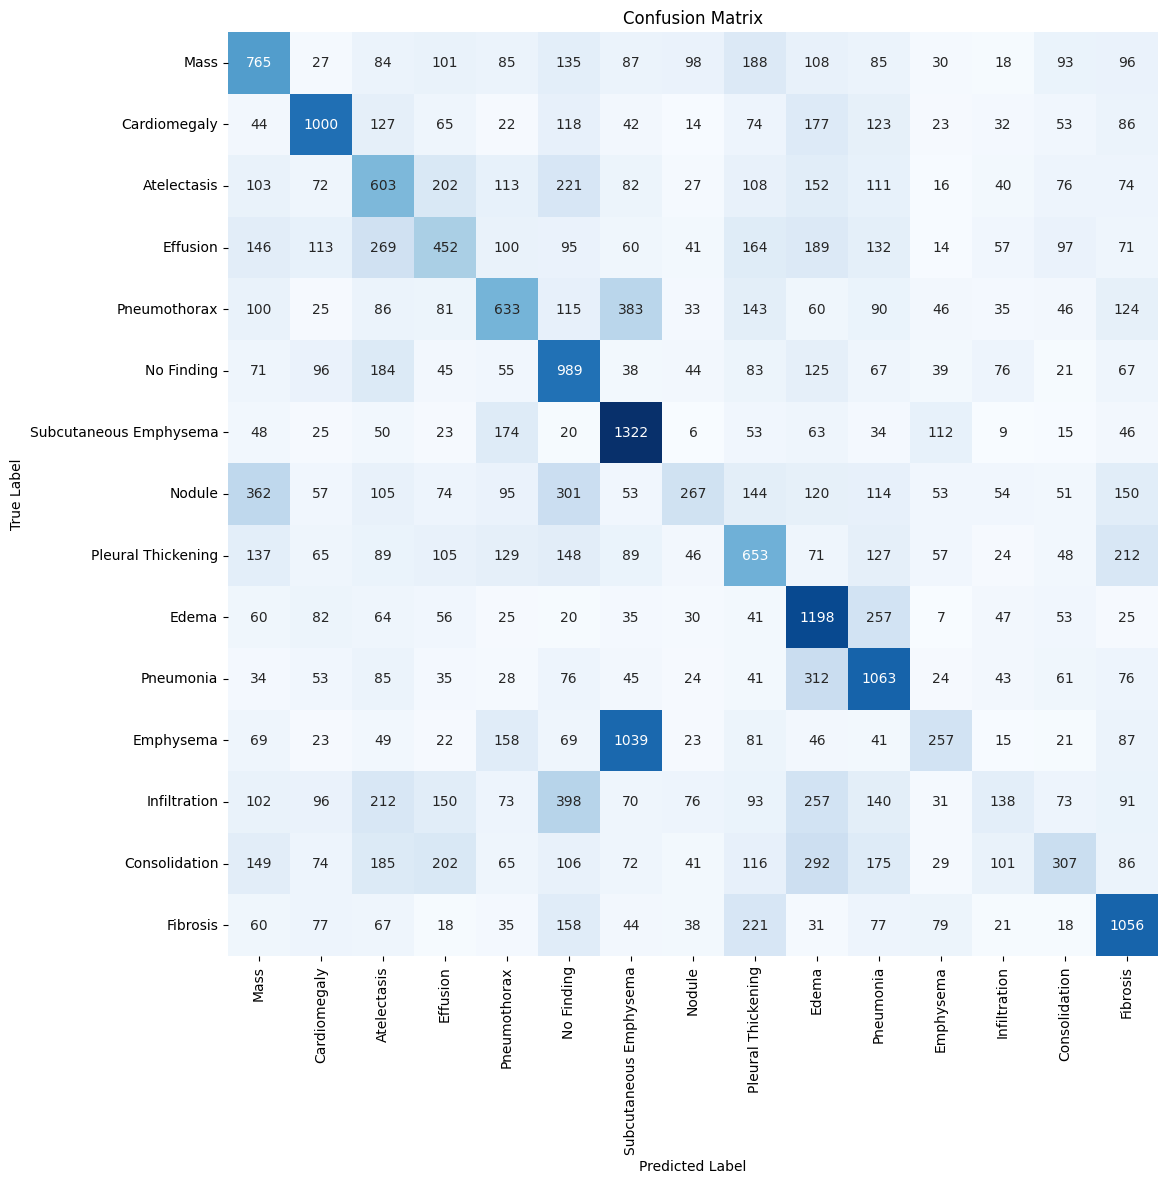

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy

criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def test_model(model, test_loader, criterion, class_names):
    model.eval()  # Set the model to evaluation mode

    running_loss = 0.0
    running_corrects = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    total_loss = running_loss / len(test_loader.dataset)
    total_acc = running_corrects.double() / len(test_loader.dataset)

    print(f'Test Loss: {total_loss:.4f} Acc: {total_acc:.4f}')

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Plotting the confusion matrix
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Predicted Label", ylabel="True Label", title="Confusion Matrix")
    ax.set_xticklabels(class_names,rotation=90)
    ax.set_yticklabels(class_names, rotation=0)
    plt.show()

    return total_loss, total_acc, conf_matrix



#class_to_idx = {class_name: index for index, class_name in enumerate(pd.unique(train_dataset.img_labels['class']))}
class_names = [class_name for class_name, _ in sorted(class_to_idx.items(), key=lambda item: item[1])]


# Initialize the model architecture
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer to match the number of classes you have (15)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 15)

# Load the state dictionary
model.load_state_dict(torch.load('/content/drive/My Drive/Capstone/model3_resnet50.pth'))

# Move the model to the device (GPU or CPU)
model = model.to(device)

# Now you can proceed with the evaluation
test_loss, test_acc, conf_matrix = test_model(model, test_loader, criterion, class_names)


## FOURTH MODEL

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import copy

# Replace with your dataset's path and transformations
from your_dataset_file import YourCustomDataset, your_transforms


# Initialize the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Freeze the parameters (weights)
for param in model.parameters():
    param.requires_grad = False

# Get the number of input features for the final fully connected layer
num_ftrs = model.fc.in_features

# Replace the final fully connected layer with a custom classifier
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, len(class_to_idx))  # Output layer with 15 classes
)

# Set up the loss function
criterion = nn.CrossEntropyLoss()

# Use AdamW optimizer (you could also use SGD or another optimizer)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.3)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Your custom dataset
train_dataset = YourCustomDataset('/path/to/train/data', transform=your_transforms)
val_dataset = YourCustomDataset('/path/to/val/data', transform=your_transforms)

# Data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in (train_loader if phase == 'train' else val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(train_loader.dataset if phase == 'train' else val_loader.dataset)
            epoch_acc = running_corrects.double() / len(train_loader.dataset if phase == 'train' else val_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Step the scheduler if in validation phase
            if phase == 'val':
                scheduler.step(epoch_loss)

            # Deep copy the model if we have the best accuracy so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model_ft = train_model(model, criterion, optimizer, scheduler, num_epochs=25)

# Save the model
model_save_path = '/content/drive/My Drive/Capstone/model3_resnet50.pth'
torch.save(model_ft.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")
